## Identifiability Test of Linear VAE on KittiMask Dataset

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import ltcl
import numpy as np
import scipy
from ltcl.datasets.kitti import KittiMasks, KittiMasksTwoSample
from ltcl.modules.srnn_cnn_kitti import SRNNConv
from ltcl.modules.linear_vae import AfflineVAECNN
from ltcl.modules.metrics.correlation import correlation
import random
import seaborn as sns
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

### Load KittiMask dataset

In [6]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
latent_size = 10
nc = 1

In [7]:
data = KittiMasksTwoSample(path = '/srv/data/ltcl/data/kitti/', 
                           transform = None,
                           max_delta_t = 5)
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=2560, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

### Load model

In [10]:
model = SRNNConv.load_from_checkpoint('/srv/data/ltcl/log/weiran/kitti_10_g25_linear/lightning_logs/version_45/checkpoints/epoch=42-step=54565.ckpt',
                                      nc=1, length=1, z_dim=10, z_dim_trans=10, lag=1, hidden_dim=512, bias=False)

In [11]:
for batch in train_loader:
    break
batch_size = batch['s1']['xt'].shape[0]

In [146]:
diag_ckp = "/data/datasets/logs/cmu_wyao/linear_vae_kitti_1lag_10_gamma_10_diag/lightning_logs/version_21/checkpoints/epoch=249-step=302999.ckpt"
lin_ckp = "/data/datasets/logs/cmu_wyao/kitti_10_g25_linear/lightning_logs/version_10/checkpoints/epoch=99-step=126899.ckpt" 

In [147]:
model = model.load_from_checkpoint(lin_ckp,
                                   z_dim = 10, nc=1, lag=1, diagonal=False, hidden_dim=512)

/home/cmu_wyao/projects/ltcl/ltcl/modules/components/beta.py:168: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [517]:
model.eval()
model.to(device)

AfflineVAECNN(
  (net): BetaVAE_CNN(
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): Conv2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
      (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running

### Visualization of MCC and causal matrix

In [137]:
for batch in train_loader:
    break
batch_size = batch['s1']['yt'].shape[0]

In [138]:
fig = plt.figure(figsize=(2,2))
eps = model.sample(batch["xt"])
eps = eps.detach().cpu().numpy()
component_idx = 7
sns.distplot(eps[:,component_idx], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2});
plt.title("Learned noise prior")

KeyError: 'xt'

<Figure size 144x144 with 0 Axes>

In [162]:
batch = next(iter(train_loader))
batch_size = batch['s1']['yt'].shape[0]

In [163]:
z, mu, logvar = model.forward(batch['s1'])
mu = mu.view(batch_size, -1, latent_size)
A = mu[:,0,:].detach().cpu().numpy().T
B = batch['s1']['yt'][:,0,:].detach().cpu().numpy().T
result = np.zeros(A.shape)
result[:B.shape[0],:B.shape[1]] = B
for i in range(len(A) - len(B)):
    result[B.shape[0] + i, :] = np.random.normal(size=B.shape[1])
    
corr_sorted, sort_idx, mu_sorted = correlation(A, result, method='Spearman')

In [192]:
mu.shape

torch.Size([2560, 2, 10])

In [184]:
figure_path = '/home/weiran/figs/'
from matplotlib.backends.backend_pdf import PdfPages

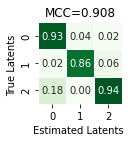

In [216]:
with PdfPages(figure_path + '/mcc_kitti.pdf') as pdf:
    fig = plt.figure(figsize=(1.5,1.5))
    sns.heatmap(np.abs(corr_sorted[:3,:3]), vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
    plt.xlabel("Estimated Latents ") 
    plt.ylabel("True Latents ")
    plt.title("MCC=%.3f"%np.abs(np.diag(corr_sorted)[:3]).mean())
    pdf.savefig(fig, bbox_inches="tight")

In [145]:
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(latent_size)
for i in range(latent_size):
    if np.corrcoef(B, A, rowvar=False)[i,latent_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 10

In [382]:
x_recon, mu, logvar, z = model.forward(batch)
mu = mu.view(batch_size, -1, latent_size)
A = mu[:,0,:].detach().cpu().numpy().T
B = batch['yt'][:,0,:].detach().cpu().numpy().T

In [180]:
result = np.zeros(A.shape)
result[:B.shape[0],:B.shape[1]] = B
for i in range(len(A) - len(B)):
    result[B.shape[0] + i, :] = np.random.normal(size=B.shape[1])
corr_sorted, sort_idx, mu_sorted = correlation(A, result, method='Spearman')

Calculating correlation...


Text(0.5, 1.0, 'MCC=0.909')

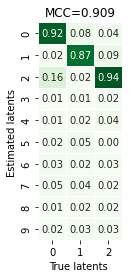

In [146]:
fig = plt.figure(figsize=(1.5,4))
sns.heatmap(np.abs(corr_sorted[:,:3]), vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
plt.xlabel("True latents ") 
plt.ylabel("Estimated latents ") 
plt.title("MCC=%.3f"%np.abs(np.diag(corr_sorted)[:3]).mean())

In [ ]:
# Model is not accurate, nonlinear
# Maybe violate no instanous relation assumption

In [148]:
col_ind = sort_idx[:3].astype('int')
print('Permutation:', col_ind)

Permutation: [7 1 6]


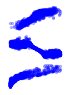

In [190]:
with PdfPages(figure_path + '/xy_kitti.pdf') as pdf:
    fig, axs = plt.subplots(3,1, figsize=(1,1.5))
    for i in range(3):
        ax = axs[i]
        ax.scatter(B.T[:,i], A.T[:,col_ind[i]], s=5, color='b', alpha=0.25)
        ax.axis('off')
    pdf.savefig(fig, bbox_inches="tight")

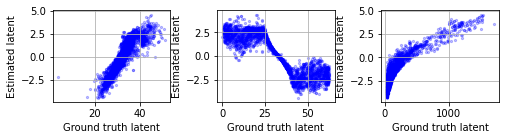

In [99]:
fig, axs = plt.subplots(1,3, figsize=(7,2))
for i in range(3):
    ax = axs[i]
    ax.scatter(B.T[:,i], A.T[:,col_ind[i]], s=5, color='b', alpha=0.25)
    ax.set_xlabel('Ground truth latent')
    ax.set_ylabel('Estimated latent')
    ax.grid('..')
fig.tight_layout()


In [206]:
col_ind = sort_idx.astype('int')

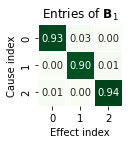

In [378]:
with PdfPages(figure_path + '/B1_kitti.pdf') as pdf:
    fig = plt.figure(figsize=(1.5,1.5))
    sns.heatmap(np.abs(model.transition_prior.transition.w[0][col_ind][:, col_ind][:3,:3].detach().cpu().numpy()),
                 annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
    plt.title(r'Entries of $\mathbf{B}_1$')
    plt.xlabel('Effect index')
    plt.ylabel('Cause index')
    pdf.savefig(fig, bbox_inches="tight")

Text(19.5, 0.5, 'Latent index')

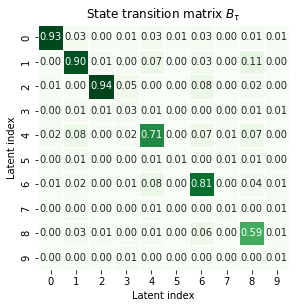

In [207]:
fig = plt.figure(figsize=(4.5,4.5))
sns.heatmap(np.abs(model.transition_prior.transition.w[0][col_ind][:, col_ind].detach().cpu().numpy()),
             annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
plt.title(r'State transition matrix $B_\tau$')
plt.xlabel('Latent index')
plt.ylabel('Latent index')

### Latent traversal

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

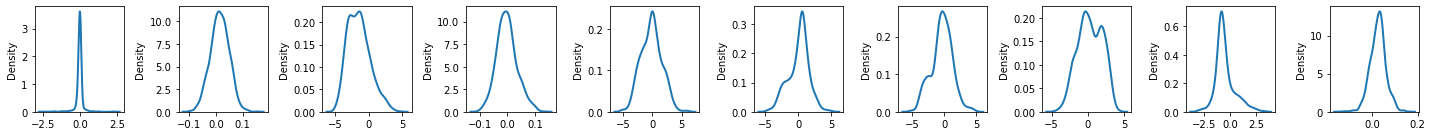

In [384]:
fig, axs = plt.subplots(1, 10, figsize=(20,2))
for idx in range(10):
    sns.distplot(mu[:,-1,idx].detach().detach().cpu().numpy(), hist=False, kde=True,
                 bins=None,
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 2},
                 ax = axs[idx])
fig.tight_layout()

In [12]:
fixed_img = torch.tensor(data.__getitem__(205)['s1']['xt'], device='cpu')
x_recon_img, mu_img, logvar_img, z_img = model.net(fixed_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 133.5, 67.5, -0.5)

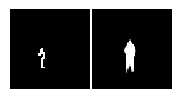

In [15]:
fig = plt.figure(figsize=(3,3))
show(make_grid(torch.cat((fixed_img[1:2], x_recon_img[1:2]), 0).detach().cpu(), pad_value=1))
plt.axis('off')

In [624]:
from torch.distributions.normal import Normal
lowest_prob = 0.05
n_steps = 6
normals = [Normal(z[:, i].mean(), z[:, i].std()) for i in range(10)]
interpolation = torch.linspace(lowest_prob, 1 - lowest_prob, steps=n_steps)

In [652]:
mu_img = mu_img.detach()[1:2]

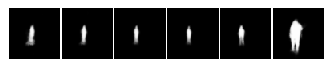

In [653]:
from torch.distributions.normal import Normal
traverse_idx = col_ind[2]
with PdfPages(figure_path + '/traversal_kitti_%d.pdf'%traverse_idx) as pdf:
    mus = normals[traverse_idx].icdf(interpolation)
    samples = [ ]
    for step in range(n_steps):
        z_trav = mu_img.clone()
        z_trav[0, traverse_idx] = mus[step]
        sample = F.sigmoid(model.net._decode(z_trav)).data
        samples.append(sample[0].detach().cpu())
    fig = plt.figure(figsize=(n_steps*1,1))
    show(make_grid(samples, pad_value=1, nrow=n_steps))
    plt.axis('off');
    pdf.savefig(fig, bbox_inches="tight")

##### Vertical position

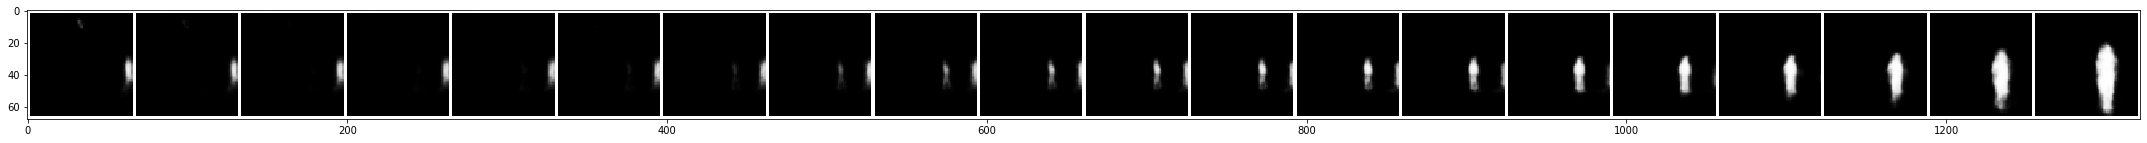

In [247]:
traverse_idx = 6 #[7,6,2,8]


##### Horizontal position

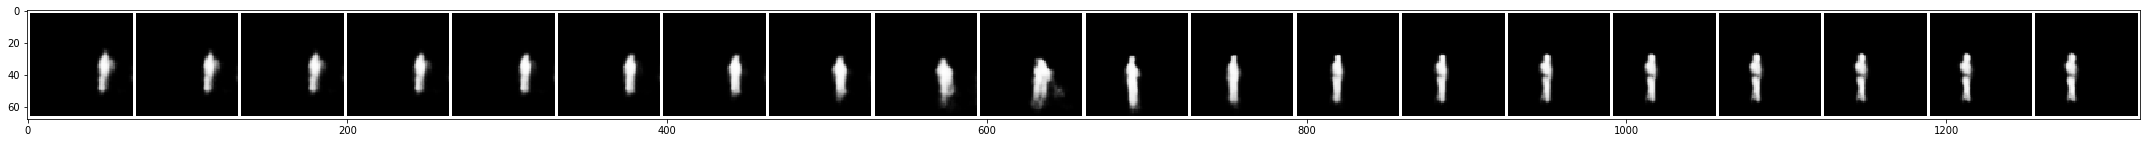

In [237]:
traverse_idx = 1 #[7,6,2,8]
samples = [ ]
for step in range(steps):
    z_trav = mu_img.detach().clone()
    z_trav[0, traverse_idx] = mus[step]
    sample = F.sigmoid(model.net._decode(z_trav)).data
    samples.append(sample[0].detach().cpu())
fig = plt.figure(figsize=(steps*2,2))
show(make_grid(samples, pad_value=1, nrow=steps))

#### Mask size

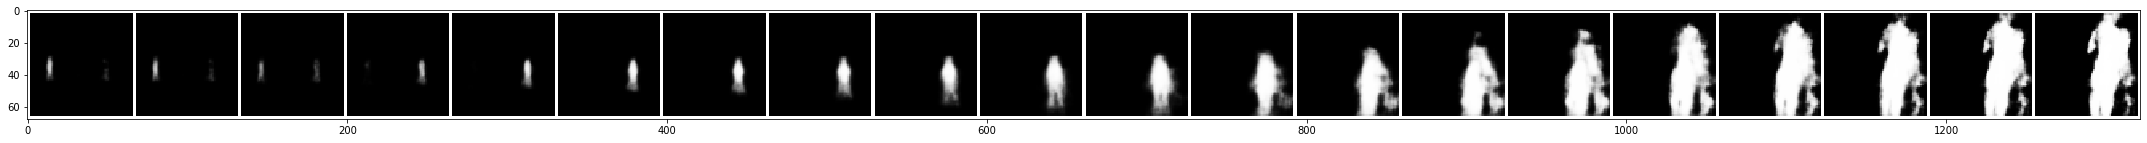

In [515]:
traverse_idx = 2 #[7,6,2,8]
samples = [ ]
for step in range(steps):
    z_trav = z.detach().clone()
    z_trav[0, traverse_idx] = mus[step]
    sample = F.sigmoid(model.net._decode(z_trav)).data
    samples.append(sample[0].detach().cpu())
fig = plt.figure(figsize=(steps*2,2))
show(make_grid(samples, pad_value=1, nrow=steps))

#### Mask rotation

This is an extra latents not found by slow-vae. It has causal relations with size, x and y.

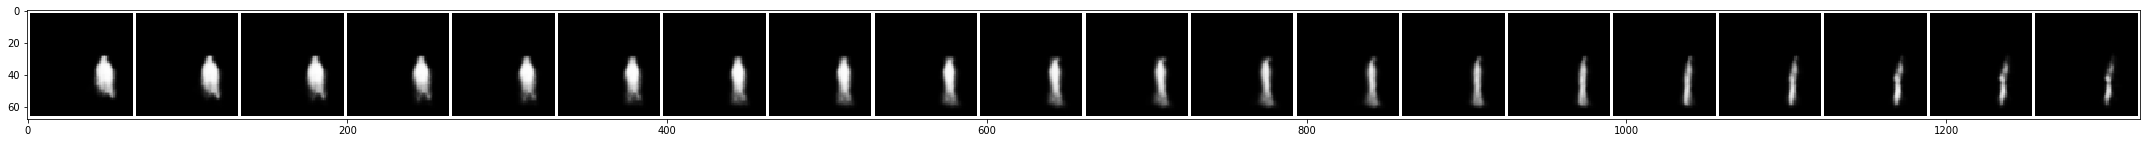

In [516]:
traverse_idx = 8 #[7,6,2,8]
samples = [ ]
for step in range(steps):
    z_trav = z.detach().clone()
    z_trav[0, traverse_idx] = mus[step]
    sample = F.sigmoid(model.net._decode(z_trav)).data
    samples.append(sample[0].detach().cpu())
fig = plt.figure(figsize=(steps*2,2))
show(make_grid(samples, pad_value=1, nrow=steps))